In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
test = pd.read_csv('test.csv')

datetime:   date and hour in "mm/dd/yyyy hh:mm" format

season:     Four categories-> 1 = spring, 2 = summer, 3 = fall, 4 = winter

holiday:    whether the day is a holiday or not (1/0)

workingday: whether the day is neither a weekend nor holiday (1/0)

weather:    Four Categories of weather

            1-> Clear, Few clouds, Partly cloudy
            2-> Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
            3-> Light Snow and Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
            4-> Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
            
temp:       hourly temperature in Celsius

atemp:      "feels like" temperature in Celsius

humidity:   relative humidity

windspeed:  wind speed

In [3]:
dt = pd.DatetimeIndex(train_df['datetime'])
train_df.set_index(dt, inplace=True)

dt_test = pd.DatetimeIndex(test_df['datetime'])
test_df.set_index(dt_test, inplace=True)

In [4]:
# logarithmic transformation of dependent cols
# (adding 1 first so that 0 values don't become -inf)
for col in ['casual', 'registered', 'count']:
    train_df['%s_log' % col] = np.log(train_df[col] + 1)

In [5]:
train_df['date'] = dt.date
train_df['day'] = dt.day
train_df['month'] = dt.month
train_df['year'] = dt.year
train_df['hour'] = dt.hour
train_df['dow'] = dt.dayofweek
train_df['woy'] = dt.weekofyear

test_df['date'] = dt_test.date
test_df['day'] = dt_test.day
test_df['month'] = dt_test.month
test_df['year'] = dt_test.year
test_df['hour'] = dt_test.hour
test_df['dow'] = dt_test.dayofweek
test_df['woy'] = dt_test.weekofyear

/tmp/ipykernel_7697/1493327584.py:7: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  train_df['woy'] = dt.weekofyear
/tmp/ipykernel_7697/1493327584.py:15: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  test_df['woy'] = dt_test.weekofyear


# Visualisation of the data

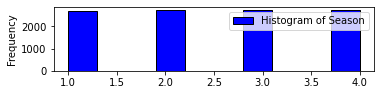

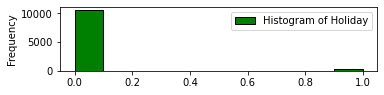

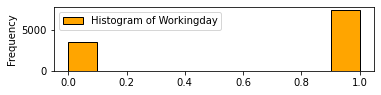

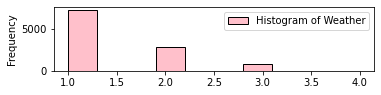

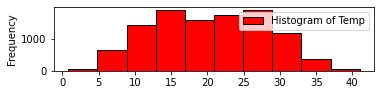

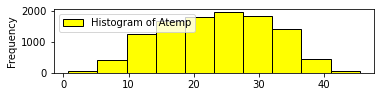

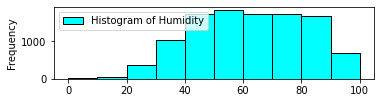

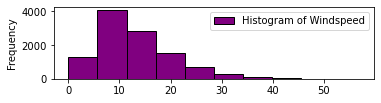

In [6]:
list_col = ['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed']
colors = ['blue', 'green', 'orange', 'pink', 'red', 'yellow', 'cyan', 'purple']
n = [421, 422, 423, 424, 425, 426, 427, 428]


for (i,c,e) in zip(list_col, colors, n):
    plt.figure(figsize=(10,5))
    plt.subplot(e)
    train_df[i].plot.hist(bins=10, color=c, label='Histogram of ' + i.capitalize(), edgecolor='black')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()


In [7]:
# add a count_season column using join
by_season = train_df.groupby(['season'])[['count']].agg(sum)
by_season.columns = ['count_season']
train_df = train_df.join(by_season, on='season')

In [8]:
# 1 = spring, 2 = summer, 3 = fall, 4 = winter
print(by_season)

        count_season
season              
1             312498
2             588282
3             640662
4             544034


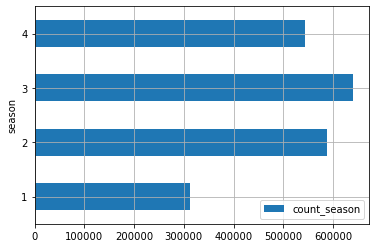

In [9]:
by_season.plot(kind='barh')
plt.grid(True)
plt.show()

<AxesSubplot:>

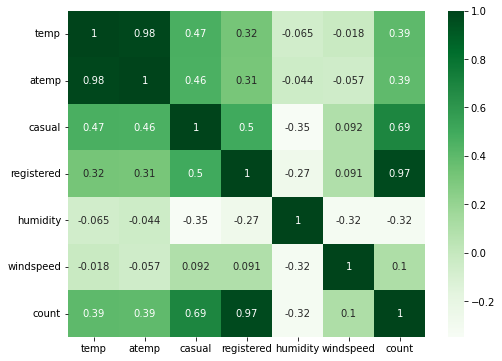

In [10]:
# heatmap for correlations
ax = plt.figure(figsize=(8,6))
pearsoncorr = train_df[["temp","atemp","casual","registered","humidity","windspeed","count"]].corr(method='pearson')
sns.heatmap(pearsoncorr, xticklabels = pearsoncorr.columns, yticklabels=pearsoncorr.columns,
            cmap = 'Greens', annot=True)

In [11]:
by_hour = train_df.copy().groupby(['hour', 'workingday'])['count'].agg('sum').unstack()
by_hour.head(10)

workingday,0,1
hour,,
0,13701,11387
1,10427,4945
2,7686,2573
3,3677,1414
4,1239,1593
5,1331,7604
6,2899,31799
7,6854,90114
8,16277,148783


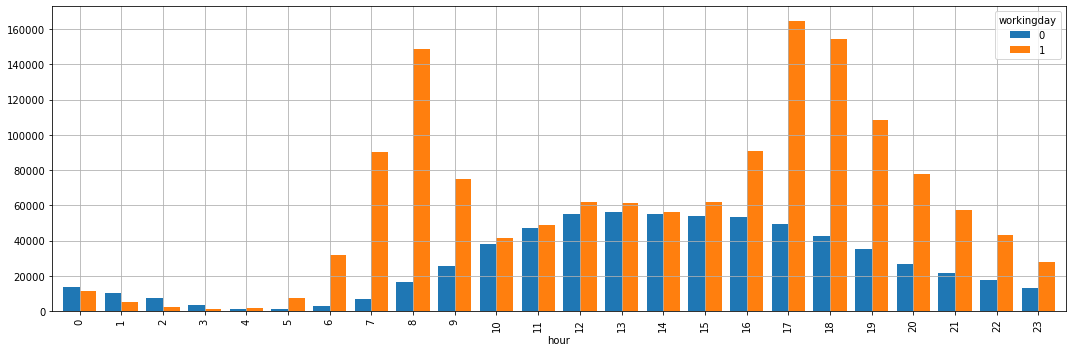

In [12]:
# rentals by hour, split by working day (or non working day)
by_hour.plot(kind='bar', figsize=(15,5), width=0.8);
plt.grid(True)
plt.tight_layout()

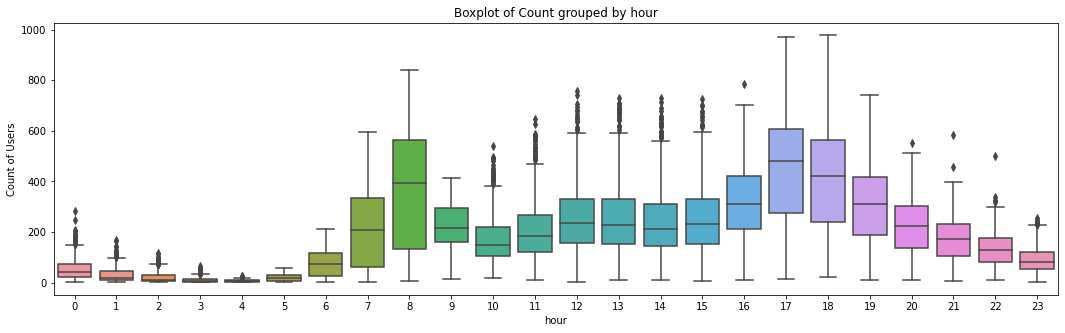

In [13]:
fig, ax = plt.subplots(figsize=(18, 5))
sns.boxplot(x=train_df['hour'], y=train_df['count'], ax=ax)
ax.set_ylabel('Count of Users')
ax.set_title("Boxplot of Count grouped by hour");
#plt.suptitle("") # get rid of the pandas autogenerated title

In [14]:
season_map = {1:'Spring', 2:'Summer', 3:'Fall', 4:'Winter'}
normal_weather = train_df[train_df['weather'] == 1][['hour', 'season']].copy()
data = pd.DataFrame({'count' : normal_weather.groupby(["hour","season"]).size()}).reset_index()
data['season'] = data['season'].map(lambda d : season_map[d])

In [15]:
data.sample(n=10)

,hour,season,count
46,11,Fall,74
66,16,Fall,84
9,2,Summer,78
84,21,Spring,83
56,14,Spring,75
80,20,Spring,82
1,0,Summer,74
36,9,Spring,73
95,23,Winter,78
18,4,Fall,83


[Text(0.5, 0, 'Hour Of The Day'),
 Text(0, 0.5, 'Normal Weather Count'),
 Text(0.5, 1.0, 'Normal Weather By Hour Of The Day Across Season')]

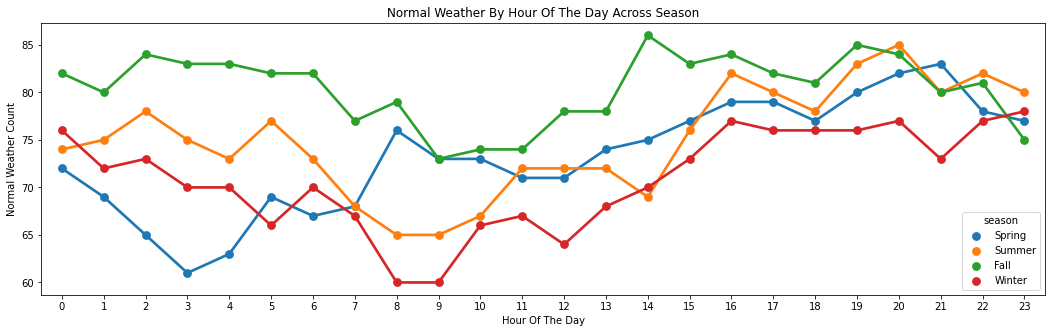

In [16]:
fig, ax = plt.subplots(figsize=(18, 5))
sns.pointplot(x=data["hour"], y=data["count"], hue=data["season"], ax=ax)
ax.set(xlabel='Hour Of The Day', ylabel='Normal Weather Count', title="Normal Weather By Hour Of The Day Across Season")

In [17]:
data = pd.pivot_table(data, values='count', columns='season', index='hour')
data.sample(5)

season,Fall,Spring,Summer,Winter
hour,,,,
23,75,77,80,78
12,78,71,72,64
16,84,79,82,77
22,81,78,82,77
9,73,73,65,60


[Text(0.5, 0, 'Hour Of The Day'),
 Text(0, 0.5, 'Bad Weather Count'),
 Text(0.5, 1.0, 'Bad Weather By Hour Of The Day Across Season')]

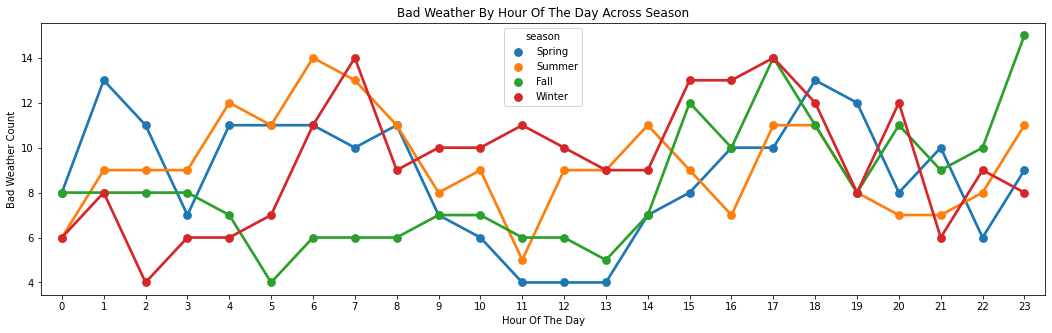

In [18]:
season_map = {1:'Spring', 2:'Summer', 3:'Fall', 4:'Winter'}
bad_weather = train_df[train_df['weather'] == 3][['hour', 'season']].copy()
data = pd.DataFrame({'count' : bad_weather.groupby(["hour","season"]).size()}).reset_index()
data['season'] = data['season'].map(lambda d : season_map[d])

fig, ax = plt.subplots(figsize=(18, 5))
sns.pointplot(x=data["hour"], y=data["count"], hue=data["season"], ax=ax)
ax.set(xlabel='Hour Of The Day', ylabel='Bad Weather Count', title="Bad Weather By Hour Of The Day Across Season")

In [19]:
sub_df = train_df[['count', 'registered', 'casual', 'temp', 'atemp', 'humidity', 'windspeed', 'workingday', 'holiday']]

In [20]:
def hour_jitter(h):
    #return h + ((np.random.randint(low=0, high=9, size=1)[0] - 4) / 10)
    return h + np.random.uniform(-0.4, 0.4)

In [21]:
def hour_format(h):
    return "{:02d}:00 AM".format(h) if h <= 12 else "{:02d}:00 PM".format(h%12)


([<matplotlib.axis.XTick at 0x7f49036c4ca0>,
 [Text(0, 0, '00:00 AM'),
  Text(1, 0, '01:00 AM'),
  Text(2, 0, '02:00 AM'),
  Text(3, 0, '03:00 AM'),
  Text(4, 0, '04:00 AM'),
  Text(5, 0, '05:00 AM'),
  Text(6, 0, '06:00 AM'),
  Text(7, 0, '07:00 AM'),
  Text(8, 0, '08:00 AM'),
  Text(9, 0, '09:00 AM'),
  Text(10, 0, '10:00 AM'),
  Text(11, 0, '11:00 AM'),
  Text(12, 0, '12:00 AM'),
  Text(13, 0, '01:00 PM'),
  Text(14, 0, '02:00 PM'),
  Text(15, 0, '03:00 PM'),
  Text(16, 0, '04:00 PM'),
  Text(17, 0, '05:00 PM'),
  Text(18, 0, '06:00 PM'),
  Text(19, 0, '07:00 PM'),
  Text(20, 0, '08:00 PM'),
  Text(21, 0, '09:00 PM'),
  Text(22, 0, '10:00 PM'),
  Text(23, 0, '11:00 PM')])

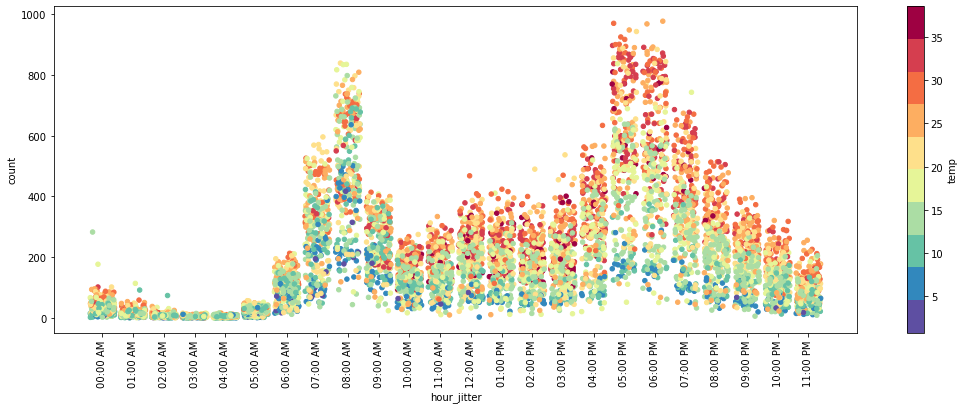

In [22]:
# for working days
# jitter plot
import matplotlib.colors as mcolors
import matplotlib.cm as cm

# color_map = plt.get_cmap("jet")
color_map = mcolors.ListedColormap(list(["#5e4fa2", "#3288bd", "#66c2a5", "#abdda4", "#e6f598", "#fee08b", "#fdae61", "#f46d43", "#d53e4f", "#9e0142"]))
train_df['hour_jitter'] = train_df['hour'].map(hour_jitter)
train_df[train_df['workingday'] == 1].plot(kind="scatter", x='hour_jitter', y='count',
    figsize=(18,6),
    c='temp', cmap=color_map, colorbar=True,
    sharex=False)

hours = np.unique(train_df['hour'].values)
hour_labels = [hour_format(h) for h in hours]
plt.xticks(hours, hour_labels, rotation='vertical')

([<matplotlib.axis.XTick at 0x7f49030aa670>,
 [Text(0, 0, '00:00 AM'),
  Text(1, 0, '01:00 AM'),
  Text(2, 0, '02:00 AM'),
  Text(3, 0, '03:00 AM'),
  Text(4, 0, '04:00 AM'),
  Text(5, 0, '05:00 AM'),
  Text(6, 0, '06:00 AM'),
  Text(7, 0, '07:00 AM'),
  Text(8, 0, '08:00 AM'),
  Text(9, 0, '09:00 AM'),
  Text(10, 0, '10:00 AM'),
  Text(11, 0, '11:00 AM'),
  Text(12, 0, '12:00 AM'),
  Text(13, 0, '01:00 PM'),
  Text(14, 0, '02:00 PM'),
  Text(15, 0, '03:00 PM'),
  Text(16, 0, '04:00 PM'),
  Text(17, 0, '05:00 PM'),
  Text(18, 0, '06:00 PM'),
  Text(19, 0, '07:00 PM'),
  Text(20, 0, '08:00 PM'),
  Text(21, 0, '09:00 PM'),
  Text(22, 0, '10:00 PM'),
  Text(23, 0, '11:00 PM')])

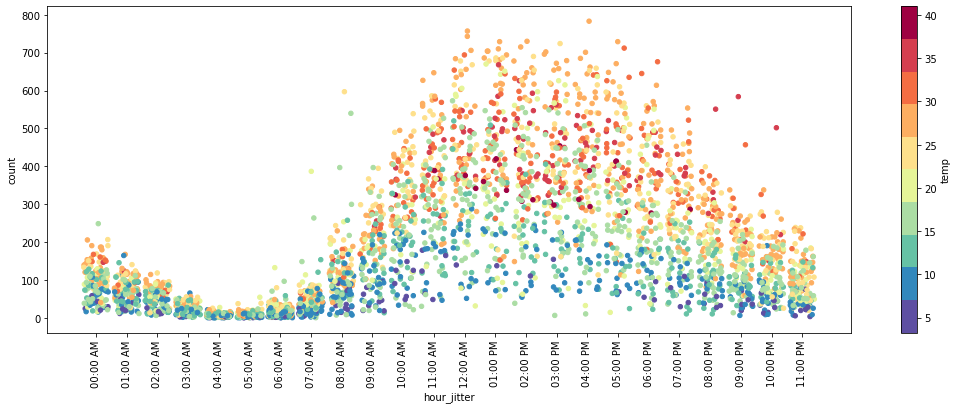

In [23]:
# for non working days
color_map = mcolors.ListedColormap(list(["#5e4fa2", "#3288bd", "#66c2a5", "#abdda4", "#e6f598", "#fee08b", "#fdae61", "#f46d43", "#d53e4f", "#9e0142"]))
train_df['hour_jitter'] = train_df['hour'].map(hour_jitter)
train_df[train_df['workingday'] == 0].plot(kind="scatter", x='hour_jitter', y='count',
    figsize=(18,6),
    c='temp', cmap=color_map, colorbar=True,
    sharex=False)

hours = np.unique(train_df['hour'].values)
hour_labels = [hour_format(h) for h in hours]
plt.xticks(hours, hour_labels, rotation='vertical')

# Feature engineering

In [24]:
list_dfs = [train_df, test_df]
def apply_changes_df(list_dfs):
    ''' apply the dataframe for the changes '''
    for df in list_dfs:
        
        df['peak'] = df[['hour', 'workingday']]\
        .apply(lambda df: 1 if ((df['workingday'] == 1 and (df['hour'] == 8 or 17 <= df['hour'] <= 18)) \
                                or (df['workingday'] == 0 and 10 <= df['workingday'] <= 19)) else 0, axis = 1)

        df['ideal'] = df[['temp', 'windspeed']]\
        .apply(lambda df: 1 if (df['temp'] > 27 and df['windspeed'] < 30) else 0, axis = 1)

        df['sticky'] = df[['humidity', 'workingday']]\
        .apply(lambda df: 1 if (df['workingday'] == 1 and df['humidity'] >= 60) else 0, axis = 1)

    
apply_changes_df(list_dfs)

In [25]:
categoricalFeatureNames = ["season","holiday","workingday","hour","weather",'ideal','sticky','peak']
numericalFeatureNames = ["temp"]
dropFeatures = ['casual_log', 'registered_log', 'count_log','count_season','casual',"datetime",
                "date","registered","atemp","hour_jitter",
                "day","month","year", 'windspeed',"humidity"
               ]

dropFeatures_test = ["datetime", "date","atemp","day","month","year",'windspeed',"humidity"]


In [26]:
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [27]:
train_df = train_df.drop(dropFeatures, axis=1)
test_df = test_df.drop(dropFeatures_test, axis=1)

In [28]:
train_df.head()

,season,holiday,workingday,weather,temp,count,hour,dow,woy,peak,ideal,sticky
0,1,0,0,1,9.84,16,0,5,52,0,0,0
1,1,0,0,1,9.02,40,1,5,52,0,0,0
2,1,0,0,1,9.02,32,2,5,52,0,0,0
3,1,0,0,1,9.84,13,3,5,52,0,0,0
4,1,0,0,1,9.84,1,4,5,52,0,0,0


In [29]:
X = train_df.loc[:, train_df.columns != 'count']
y = train_df["count"]

In [30]:
for var in categoricalFeatureNames:
    train_df[var] = train_df[var].astype("category")
    test_df[var] = test_df[var].astype("category")
    

In [31]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import KBinsDiscretizer

In [32]:
numeric_transformer = make_pipeline(SimpleImputer(strategy="mean"),
                                    #KBinsDiscretizer(n_bins=9,encode='onehot-dense',strategy='quantile'),
                                    #FunctionTransformer(log_transform),
                                    StandardScaler()
                                   )

In [33]:
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numericalFeatureNames),
        ("dummy_variable", OneHotEncoder(handle_unknown="ignore", sparse=False), categoricalFeatureNames)
    ],
    remainder='passthrough')


In [34]:
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.model_selection import GridSearchCV

pipeline = make_pipeline(preprocessor,
                         LinearRegression()
                        )

In [35]:
def rmsle(y_pred, y_actual):
    diff = np.log(y_pred + 1) - np.log(y_actual + 1)
    mean_error = np.square(diff).mean()
    return np.sqrt(mean_error)



In [36]:
from sklearn.metrics import mean_squared_log_error
# np.sqrt(mean_squared_log_error(y_test, predictions)) 

In [37]:
X_train, x_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=42)

In [38]:
pipeline.fit(X_train, y_train)

print("model score: %.3f" % pipeline.score(x_test, y_test))


model score: 0.667


In [39]:
from sklearn.metrics import mean_squared_error

y_pred = pipeline.predict(x_test)
# predictions_test_df = pipeline.predict(test_df)
print ("RMSLE Value For Linear Regression In Validation: ", rmsle(y_test, y_pred))




# print(np.sqrt(mean_squared_log_error(y_test, y_pred)))


RMSLE Value For Linear Regression In Validation:  0.8009745131024559


/tmp/ipykernel_7697/4053257555.py:2: RuntimeWarning: invalid value encountered in log
  diff = np.log(y_pred + 1) - np.log(y_actual + 1)


In [40]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

# Finding best parameters for decision tree
dt = DecisionTreeRegressor(random_state=0)

#param_grids={'lr__C':[0.001,0.1,2,10],
            # 'lr__penalty':['l1','l2']}

pipeline_decision_tree = make_pipeline(preprocessor,
                         DecisionTreeRegressor(random_state=0, max_depth=20)
                        )

#gs = GridSearchCV(pipeline_decision_tree, param_grids, cv=3)
pipeline_decision_tree.fit(X_train,y_train)
#a = gs.best_params_

predictions_tree = pipeline_decision_tree.predict(x_test)
print ("RMSLE Value For Linear Regression In Validation: ", rmsle(y_test, predictions_tree))


print(np.sqrt(mean_squared_log_error(y_test, predictions_tree)))


RMSLE Value For Linear Regression In Validation:  0.6001936611652194
0.6001936611652193


In [41]:
pipeline_random_forest = make_pipeline(preprocessor, RandomForestRegressor(n_estimators=100))

In [42]:
pipeline_random_forest.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['temp']),
                                                 ('dummy_variable',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['season', 'holiday',
                                                   'workingday', 'hour',
                                                   'weather',

In [43]:
preds2 = pipeline_random_forest.predict(x_test)
predictions_test_df = pipeline_random_forest.predict(test_df)

print ("RMSLE Value For Linear Regression In Validation: ", rmsle(y_test,preds2))

print(np.sqrt(mean_squared_log_error(preds2, y_test)))

RMSLE Value For Linear Regression In Validation:  0.4619368537415812
0.461936853741581


In [44]:
X_train

,season,holiday,workingday,weather,temp,hour,dow,woy,peak,ideal,sticky
613,1,0,1,1,9.02,17,1,6,1,0,0
4030,3,0,0,1,22.14,23,6,37,0,0,0
3582,3,0,1,1,26.24,4,4,33,0,0,1
10101,4,0,1,1,9.02,6,1,45,0,0,1
1430,2,0,1,3,13.12,11,1,14,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
5734,1,0,0,1,6.56,2,5,2,0,0,0
5191,4,0,0,1,11.48,9,5,49,0,0,0
5390,4,0,0,1,11.48,16,6,50,0,0,0
860,1,0,0,1,15.58,7,5,7,0,0,0


In [45]:
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.model_selection import GridSearchCV

# Initialize logistic regression model
lModel = LinearRegression()

# Train the model
lModel.fit(X = X_train,y = y_train)

# Make predictions
predsL = lModel.predict(X= x_test)
print ("RMSLE Value For Linear Regression In Validation: ",rmsle(y_test,predsL))


# print(np.sqrt(mean_squared_log_error(y_test, predsL)))

RMSLE Value For Linear Regression In Validation:  1.1211912587310287


/tmp/ipykernel_7697/4053257555.py:2: RuntimeWarning: invalid value encountered in log
  diff = np.log(y_pred + 1) - np.log(y_actual + 1)


In [46]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

ridge_m_ = Ridge()
ridge_params_ = { 'max_iter':[3000],'alpha':[0.01,0.05,0.1, 1, 2, 3, 4, 10, 30,100,200,300,400,800,900,1000]}
rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better=False)
grid_ridge_m = GridSearchCV( ridge_m_,
                          ridge_params_,
                          scoring = rmsle_scorer,
                          cv=5)
grid_ridge_m.fit(X = X_train,y = np.log1p(y_train))
predsR = grid_ridge_m.predict(X= x_test)
print (grid_ridge_m.best_params_)
print ("RMSLE Value For Ridge Regression: ",rmsle(np.exp(np.log1p(y_test)),np.exp(predsR)))

print(np.sqrt(mean_squared_log_error(y_test, predsR))) # ??? why

{'alpha': 0.01, 'max_iter': 3000}
RMSLE Value For Ridge Regression:  0.9609599645842137
3.171682929236984


In [47]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
lasso_m_ = Lasso()
alpha  = [0.001,0.005,0.01,0.3,0.1,0.3,0.5,0.7,1]
lasso_params_ = { 'max_iter':[500],'alpha':alpha}
rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better=False)
grid_lasso_m = GridSearchCV( lasso_m_,
                          lasso_params_,
                          scoring = rmsle_scorer,
                          cv=5)
grid_lasso_m.fit(X = X_train,y = np.log1p(y_train))
preds = grid_lasso_m.predict(X= x_test)
print (grid_lasso_m.best_params_)
print ("RMSLE Value: ",rmsle(y_test,np.exp(preds)))

{'alpha': 0.001, 'max_iter': 500}
RMSLE Value:  0.9995847478532365


In [48]:
rf = RandomForestRegressor(max_depth=10, random_state=0)

In [49]:
rf.fit(X=X_train, y=y_train)

RandomForestRegressor(max_depth=10, random_state=0)

In [50]:
pd.DataFrame({'importance': rf.feature_importances_, 'feature': X_train.columns}).\
sort_values('importance', ascending=False)  #feature_importance- use for RF model

,importance,feature
5,0.507978,hour
8,0.212388,peak
4,0.121609,temp
7,0.054177,woy
3,0.030209,weather
2,0.026885,workingday
6,0.019217,dow
0,0.017693,season
10,0.006115,sticky
9,0.002588,ideal


In [51]:
rf.score(X_train, y_train)

0.8846626752113189

In [52]:
rf.score(x_test, y_test)

0.8242093312657925

In [53]:
preds3 = rf.predict(X= x_test)
#predictions_test_df = rf.predict(test_df)

In [54]:
print ("RMSLE Value For Random Forest: ",rmsle(y_test,preds3))
print(np.sqrt(mean_squared_log_error(y_test, preds3)))

RMSLE Value For Random Forest:  0.4478998143401305
0.4478998143401305


<AxesSubplot:xlabel='features', ylabel='coefficient'>

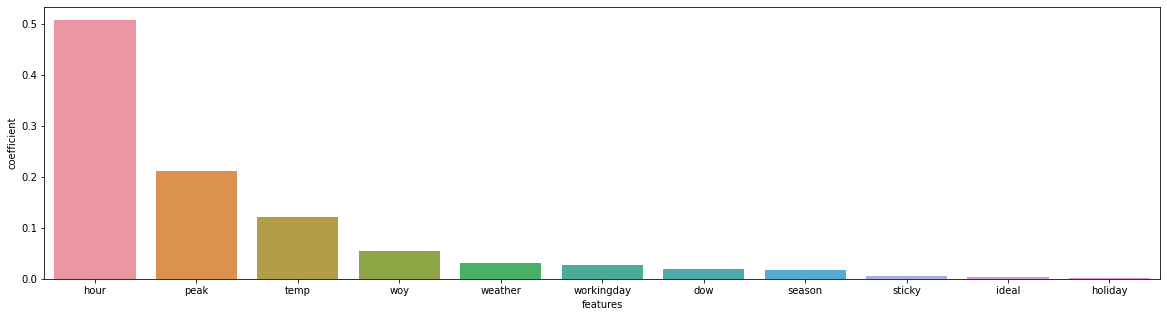

In [55]:
features = pd.DataFrame()
features['features'] =X_train.columns
features['coefficient'] = rf.feature_importances_
features.sort_values(by=['coefficient'],ascending=False,inplace=True)
fig,ax= plt.subplots()
fig.set_size_inches(20,5)
sns.barplot(data=features,x="features",y="coefficient",ax=ax)

In [56]:
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import cross_val_score

In [57]:
rf_opt = RandomForestClassifier()

In [58]:
hyperparam_grid = {
    'max_depth': [2, 5, 10, 20, 30], 
    'n_estimators': [5, 10, 100, 200],
    'min_samples_leaf': [1,5,10]
}


In [59]:
grid_cv = GridSearchCV(estimator=rf_opt,            # unfitted model/estimator
                       param_grid=hyperparam_grid,  # hyperparameters dict
                       cv=5,                        # number of folds, k
                       scoring='accuracy')

In [60]:
submission = pd.DataFrame({
        "datetime": test.datetime,
        "count": predictions_test_df
    })
submission.to_csv('bike_predictions_gbm_results.csv', index=False)

In [61]:
# kaggle score = 0.53